### Import Libraries

In [1]:
#Deafult Libs
import os 
import pandas as pd 
import numpy as np 
from tqdm import tqdm
import IPython.display as ipd
import matplotlib.pyplot as plt 
%matplotlib inline 

#ML Libs
from sklearn.preprocessing import LabelEncoder 
from sklearn.ensemble import RandomForestClassifier 

#Audio Libs
import librosa
import librosa.display
from scipy.io import wavfile as wav

#Dl Libs
import tensorflow as tf 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten 
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime

### Read and plot a Sample Audio File

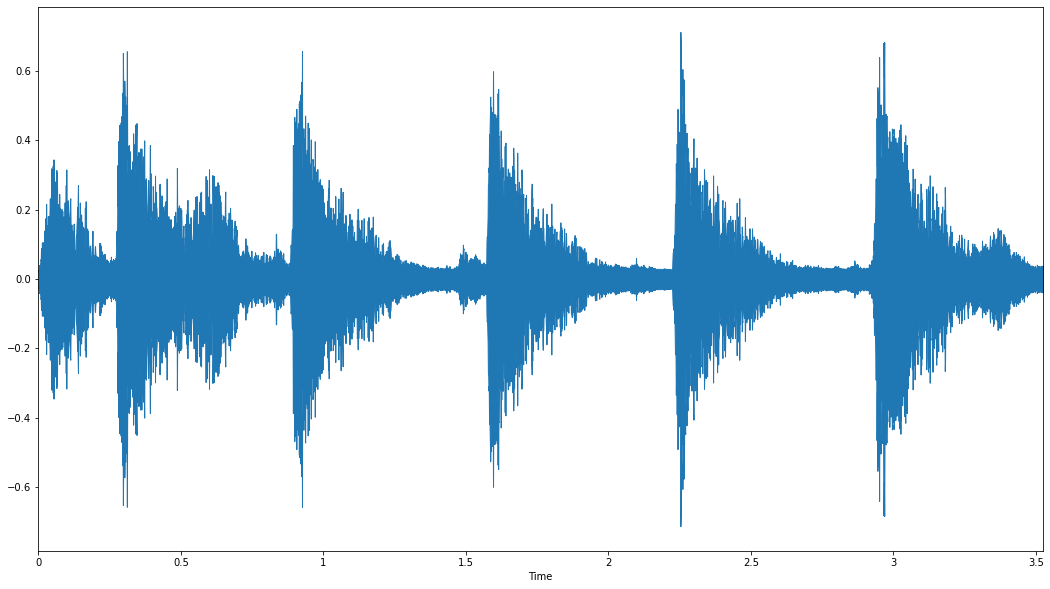

In [3]:
filename = r"sample_audio/dog_bark.wav" 
data, rate = librosa.load(filename)

# display the wave 
plt.figure(figsize = (18,10))
librosa.display.waveplot(data, sr = rate)
ipd.Audio(filename)

#mono channel

In [4]:
# data - Audio data (Total Samples)
# rate - Sample Rate (Total Samples each second)
print(data, rate)

#22khz audio rate

[0.01388212 0.02055149 0.01845404 ... 0.01507499 0.01250785 0.01730848] 22050


In [5]:
print(data.shape)

(77752,)


In [6]:
# Total time of Audio 
Total_sample = len(data)
Total_sample_per_second = 22050
print("Length of Audio file in seconds ", Total_sample / Total_sample_per_second)

Length of Audio file in seconds  3.5261678004535146


### Read the Main Urban dataset

In [7]:
metadata = pd.read_csv(r"dataset/UrbanSound8k/metadata/UrbanSOund8k.csv")
metadata.head()

slice_file_name    fsID  start        end  salience  fold  classID  \
0    100032-3-0-0.wav  100032    0.0   0.317551         1     5        3   
1  100263-2-0-117.wav  100263   58.5  62.500000         1     5        2   
2  100263-2-0-121.wav  100263   60.5  64.500000         1     5        2   
3  100263-2-0-126.wav  100263   63.0  67.000000         1     5        2   
4  100263-2-0-137.wav  100263   68.5  72.500000         1     5        2   

              class  
0          dog_bark  
1  children_playing  
2  children_playing  
3  children_playing  
4  children_playing

#### Abbreviation
- Slice_file_name : Name of Audio file
- Class : Which class does the audio file beliong to
- Fold : The Folder number

### Check the Distribution of data

In [8]:
metadata['class'].value_counts()

engine_idling       1000
dog_bark            1000
street_music        1000
drilling            1000
children_playing    1000
air_conditioner     1000
jackhammer          1000
siren                929
car_horn             429
gun_shot             374
Name: class, dtype: int64

#### Everthing seems good

### Let's plot the audio file using SciPy.io 

In [9]:
from scipy.io import wavfile as wav
filename = r"sample_audio/dog_bark.wav"
wav_rate, wav_audio = wav.read(filename)

In [11]:
print(wav_rate)

# 44khz sample rate

44100


In [12]:
print(wav_audio , len(wav_audio))

[[418 814]
 [423 821]
 [424 820]
 ...
 [115 815]
 [163 866]
 [270 974]] 155504


In [13]:
155504 / 44100

3.5261678004535146

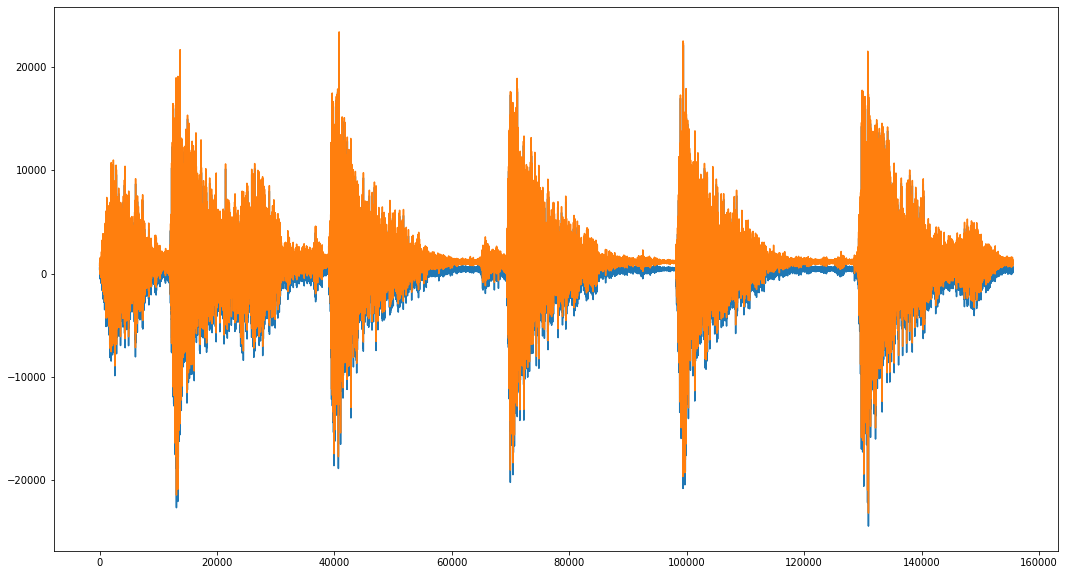

In [16]:
#dual channel
plt.figure(figsize = (18,10))
plt.plot(wav_audio)

### Features
- Independent features - data array [Mfcc feat] of .wav file 
- Dependent feature - y class label

- MFCC [ Mel frequency Cepstral Co-Efficients]

### Bring all the feature for a sample file

In [18]:
#Using MFCC Fun from Librosa 
# Data and Rate are output of librosa.load() 

mfcc_feat = librosa.feature.mfcc(data, sr = rate, n_mfcc = 40)
print(mfcc_feat)
print()
print(len(mfcc_feat))
print()
print(np.mean(mfcc_feat.T, axis =0))

[[-202.79225    -133.87383    -101.61297    ... -322.41827
  -347.2732     -354.28802   ]
 [  88.54477      65.58233      43.783463   ...   -7.358984
     9.616228     22.265816  ]
 [ -40.6801      -48.4251      -59.346577   ...  -91.52024
   -81.8056      -83.028625  ]
 ...
 [   4.5832977    12.646073     11.840952   ...    1.4140205
     3.0540786     5.882844  ]
 [   4.649735      5.2733135     6.06935    ...    0.66383886
     2.5493987     4.213949  ]
 [  11.529855      7.155142      4.531093   ...    8.224231
     6.5936027     2.5573213 ]]

40

[-211.36977      57.998665    -90.22551     -19.072058    -65.18957
    1.0798622   -19.15974       8.3762455     5.402468     13.059355
    6.22276       9.600141     11.21357      -4.1172976    -2.1146598
   -1.3209494     6.0108314     8.440462      5.6783504    11.740493
    8.064862     10.877564      0.32161656    6.6484885     2.9225094
    4.0159388     1.1648941     4.8856306     5.7622375     6.6762047
    5.6823287     6.394661

### Steps of Extracting Features from Audio file
- Grouping all the .wav file and gathering their data array using librosa and OS Module 
- pass data array into mfcc calculation to generate mfcc_feat 
- function : librosa.feature.mfcc()


### MFCC_Generator function

In [19]:
def mfcc_extractor(file_name):
    audio_data, sample_rate = librosa.load(file_name)
    mfcc_feat = librosa.feature.mfcc(audio_data, sr = sample_rate, n_mfcc = 40)
    mfcc_scaled_feat = np.mean(mfcc_feat.T, axis = 0)
    
    return mfcc_scaled_feat
    

In [20]:
# Testing for a single audio file
print(mfcc_extractor(filename))


[-211.36977      57.998665    -90.22551     -19.072058    -65.18957
    1.0798622   -19.15974       8.3762455     5.402468     13.059355
    6.22276       9.600141     11.21357      -4.1172976    -2.1146598
   -1.3209494     6.0108314     8.440462      5.6783504    11.740493
    8.064862     10.877564      0.32161656    6.6484885     2.9225094
    4.0159388     1.1648941     4.8856306     5.7622375     6.6762047
    5.6823287     6.394661      4.12801       6.0095644     3.0415473
    5.829633      3.7204585     6.872272      4.182897      6.620342  ]


In [21]:
# Iterate for all folds and wav file

audio_path = "dataset/UrbanSound8k/audio"

extracted_mfcc_feat = [] 
for index, row in tqdm(metadata.iterrows()):
    f_name = os.path.join(os.path.abspath(audio_path), "fold"+str(row["fold"]) + "/", str(row["slice_file_name"]))
    f_class_name = row["class"]
    data_extracted = mfcc_extractor(f_name)
    extracted_mfcc_feat.append([data_extracted, f_class_name])                                                                                         
    

3555it [35:52,  1.24it/s]c:\users\manish sharma\appdata\local\programs\python\python38\lib\site-packages\librosa\core\spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1323
  warnings.warn(
8326it [58:43,  9.67it/s]c:\users\manish sharma\appdata\local\programs\python\python38\lib\site-packages\librosa\core\spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1103
  warnings.warn(
c:\users\manish sharma\appdata\local\programs\python\python38\lib\site-packages\librosa\core\spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1523
  warnings.warn(
8732it [59:54,  2.43it/s]


### Converting these features into dataframe, and pass it into ML and DL Model

In [23]:
# Build Dataframe 
main_df = pd.DataFrame(extracted_mfcc_feat, columns = ['feature','class'])

main_df.to_csv("Audio_Data_Extracted.csv" , index = False)
main_df.head()

feature             class
0  [-209.93578, 63.42263, -123.69025, -60.0192, -...          dog_bark
1  [-417.29105, 100.148506, -43.86925, 51.953114,...  children_playing
2  [-452.77457, 113.24303, -38.501553, 44.0628, 7...  children_playing
3  [-406.86542, 92.06992, -25.97457, 43.714268, 1...  children_playing
4  [-440.05148, 104.7528, -43.601677, 51.623074, ...  children_playing

In [24]:
x = np.array(main_df['feature'].tolist())
y = np.array(main_df['class'].tolist())

In [25]:
x[:10]

array([[-2.09935776e+02,  6.34226303e+01, -1.23690247e+02,
        -6.00191994e+01, -1.44573841e+01, -2.90906410e+01,
        -4.25117779e+00,  1.24197493e+01,  1.27393017e+01,
         9.05396461e+00, -6.80807781e+00, -2.13655901e+00,
        -1.33499527e+01,  6.67802572e+00, -3.14479399e+00,
        -3.69539261e+00, -1.57681942e+01, -3.87185723e-01,
        -3.25079346e+00,  6.49081135e+00, -1.13526125e+01,
        -7.68830252e+00,  5.41635513e+00, -2.70299292e+00,
        -6.27998018e+00,  4.52575773e-01, -3.87933898e+00,
         5.36968994e+00, -6.66416550e+00, -4.45491791e+00,
         3.97254437e-01,  8.10058784e+00, -1.07305419e+00,
         2.72070885e+00, -6.71397543e+00, -1.87979043e+00,
         2.01220822e+00, -6.62542641e-01, -1.89823115e+00,
         1.35495269e+00],
       [-4.17291046e+02,  1.00148506e+02, -4.38692513e+01,
         5.19531136e+01,  9.04440594e+00,  8.78020668e+00,
         1.03759212e+01,  2.73138785e+00,  6.17525816e+00,
         5.06514311e+00, -4.37

In [26]:
y[:10]

array(['dog_bark', 'children_playing', 'children_playing',
       'children_playing', 'children_playing', 'children_playing',
       'children_playing', 'children_playing', 'children_playing',
       'car_horn'], dtype='<U16')

In [41]:
# Label Encode y

from sklearn.preprocessing import LabelEncoder 
le = LabelEncoder() 
main_df['class_label'] = le.fit_transform(main_df['class'])

In [42]:
y = main_df['class_label']

In [43]:
main_df.head()

feature             class  \
0  [-209.93578, 63.42263, -123.69025, -60.0192, -...          dog_bark   
1  [-417.29105, 100.148506, -43.86925, 51.953114,...  children_playing   
2  [-452.77457, 113.24303, -38.501553, 44.0628, 7...  children_playing   
3  [-406.86542, 92.06992, -25.97457, 43.714268, 1...  children_playing   
4  [-440.05148, 104.7528, -43.601677, 51.623074, ...  children_playing   

   class_label  
0            3  
1            2  
2            2  
3            2  
4            2

In [44]:
main_df['class_label'].unique()

array([3, 2, 1, 0, 9, 6, 8, 5, 7, 4])

In [45]:
main_df['class'].unique()

array(['dog_bark', 'children_playing', 'car_horn', 'air_conditioner',
       'street_music', 'gun_shot', 'siren', 'engine_idling', 'jackhammer',
       'drilling'], dtype=object)

### Splitting Data and Training on ML Model 

In [46]:
# split data 
from sklearn.model_selection import train_test_split 
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify = y, test_size =0.3, random_state = 100 )

In [47]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(6112, 40)
(2620, 40)
(6112,)
(2620,)


In [48]:
# Using Bagging Model (Rf)
from sklearn.ensemble import RandomForestClassifier 

In [49]:
rf = RandomForestClassifier()

In [50]:
rf.fit(x_train, y_train)

RandomForestClassifier()

In [51]:
from sklearn.metrics import accuracy_score, confusion_matrix
pred = rf.predict(x_test)

print(accuracy_score(pred, y_test)) 

print(confusion_matrix(pred, y_test))

0.8870229007633588
[[293   0   2   3   1   0   0   1   0   2]
 [  0 112   1   1   0   0   0   0   1   2]
 [  2   5 259  31   5  10   8   0   4  26]
 [  0   2  10 233   4   0  21   0   5   5]
 [  0   1   4   6 263   0   2   2   1   5]
 [  2   0   0   4   1 285   0   0   0   3]
 [  0   0   0   2   0   0  75   0   0   0]
 [  2   4   9   1  11   1   2 297   1   7]
 [  0   0   4   7   1   2   2   0 264   7]
 [  1   5  11  12  14   2   2   0   3 243]]


In [52]:
y_train

2451    8
7753    0
7282    4
7040    9
7907    4
       ..
7081    5
7617    1
3398    6
4435    2
2067    5
Name: class_label, Length: 6112, dtype: int32

In [53]:
# Tesing on a Random Input

testing = main_df['feature'][2451]

print(rf.predict([testing]))


[8]


- ############################################################################################################## .

### Let's now build a Deep Neural Network Model 

In [54]:
import tensorflow as tf 
print(tf.__version__)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten 
from tensorflow.keras.optimizers import Adam 


2.3.1


In [55]:
# For DL Model, we have to One Hot Encode the y-variable (Class)

In [56]:
x = np.array(main_df['feature'].tolist())
y = np.array(main_df['class'].tolist())

#OneHot Encoding
y = pd.get_dummies(main_df['class'])
print(y)
# split data again
from sklearn.model_selection import train_test_split 
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify = y, test_size =0.3, random_state = 100 )

      air_conditioner  car_horn  children_playing  dog_bark  drilling  \
0                   0         0                 0         1         0   
1                   0         0                 1         0         0   
2                   0         0                 1         0         0   
3                   0         0                 1         0         0   
4                   0         0                 1         0         0   
...               ...       ...               ...       ...       ...   
8727                0         1                 0         0         0   
8728                0         1                 0         0         0   
8729                0         1                 0         0         0   
8730                0         1                 0         0         0   
8731                0         1                 0         0         0   

      engine_idling  gun_shot  jackhammer  siren  street_music  
0                 0         0           0      0          

In [57]:
print(y_train.shape)
print(x_train.shape)

(6112, 10)
(6112, 40)


In [58]:
num_label = 10
input_size = x_train.shape[1]
# or num of columns

In [125]:
# Creating Deep Neural Network Model

model = Sequential() 

#first layer 
model.add(Dense(64, input_shape = (40,)))
model.add(Activation("relu"))
model.add(Dropout(0.3))

#second layer 
model.add(Dense(128))
model.add(Activation("sigmoid"))
model.add(Dropout(0.5))

#third layer 
model.add(Dense(256))
model.add(Activation("sigmoid"))
model.add(Dropout(0.5))

#final layer 
model.add(Dense(10))
model.add(Activation("softmax"))


In [126]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 64)                2624      
_________________________________________________________________
activation_25 (Activation)   (None, 64)                0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_26 (Dense)             (None, 128)               8320      
_________________________________________________________________
activation_26 (Activation)   (None, 128)               0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 256)              

In [127]:
model.compile(loss = "categorical_crossentropy",
             metrics = ["accuracy"],
             optimizer = "adam")

In [128]:
x_test.shape, y_test.shape, x_train.shape, y_train.shape

((2620, 40), (2620, 10), (6112, 40), (6112, 10))

### Training DL Model

In [129]:
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime

num_epochs = 180
num_batch_size = 32

checkpointer = ModelCheckpoint(filepath= r'saved_models/audio_classification_main.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()


model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(x_test, y_test), callbacks=[checkpointer], verbose=1)

duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/180
164/191 [========================>.....] - ETA: 0s - loss: 2.3811 - accuracy: 0.1412
Epoch 00001: val_loss improved from inf to 2.01091, saving model to saved_models\audio_classification_main.hdf5
191/191 [==============================] - 0s 2ms/step - loss: 2.3585 - accuracy: 0.1473 - val_loss: 2.0109 - val_accuracy: 0.3095
Epoch 2/180
191/191 [==============================] - ETA: 0s - loss: 2.0639 - accuracy: 0.2457
Epoch 00002: val_loss improved from 2.01091 to 1.76774, saving model to saved_models\audio_classification_main.hdf5
191/191 [==============================] - 0s 2ms/step - loss: 2.0639 - accuracy: 0.2457 - val_loss: 1.7677 - val_accuracy: 0.3786
Epoch 3/180
189/191 [============================>.] - ETA: 0s - loss: 1.8801 - accuracy: 0.3189
Epoch 00003: val_loss improved from 1.76774 to 1.60012, saving model to saved_models\audio_classification_main.hdf5
191/191 [==============================] - 0s 2ms/step - loss: 1.8805 - accuracy: 0.3184 - val_loss: 1.

Epoch 25/180
170/191 [=========================>....] - ETA: 0s - loss: 0.9799 - accuracy: 0.6715
Epoch 00025: val_loss improved from 0.81599 to 0.81020, saving model to saved_models\audio_classification_main.hdf5
191/191 [==============================] - 0s 2ms/step - loss: 0.9793 - accuracy: 0.6697 - val_loss: 0.8102 - val_accuracy: 0.7351
Epoch 26/180
163/191 [========================>.....] - ETA: 0s - loss: 0.9677 - accuracy: 0.6787
Epoch 00026: val_loss did not improve from 0.81020
191/191 [==============================] - 0s 2ms/step - loss: 0.9694 - accuracy: 0.6787 - val_loss: 0.8107 - val_accuracy: 0.7324
Epoch 27/180
173/191 [==========================>...] - ETA: 0s - loss: 0.9689 - accuracy: 0.6772
Epoch 00027: val_loss did not improve from 0.81020
191/191 [==============================] - 0s 2ms/step - loss: 0.9690 - accuracy: 0.6760 - val_loss: 0.8127 - val_accuracy: 0.7317
Epoch 28/180
164/191 [========================>.....] - ETA: 0s - loss: 0.9797 - accuracy: 0.66

Epoch 78/180
153/191 [=======================>......] - ETA: 0s - loss: 0.7289 - accuracy: 0.7606
Epoch 00078: val_loss did not improve from 0.61562
191/191 [==============================] - 0s 2ms/step - loss: 0.7377 - accuracy: 0.7577 - val_loss: 0.6176 - val_accuracy: 0.8004
Epoch 79/180
173/191 [==========================>...] - ETA: 0s - loss: 0.7480 - accuracy: 0.7520
Epoch 00079: val_loss did not improve from 0.61562
191/191 [==============================] - 0s 1ms/step - loss: 0.7492 - accuracy: 0.7518 - val_loss: 0.6248 - val_accuracy: 0.8004
Epoch 80/180
157/191 [=======================>......] - ETA: 0s - loss: 0.7379 - accuracy: 0.7584
Epoch 00080: val_loss did not improve from 0.61562
191/191 [==============================] - 0s 2ms/step - loss: 0.7412 - accuracy: 0.7574 - val_loss: 0.6175 - val_accuracy: 0.7973
Epoch 81/180
162/191 [========================>.....] - ETA: 0s - loss: 0.7435 - accuracy: 0.7515
Epoch 00081: val_loss improved from 0.61562 to 0.61307, saving

Epoch 106/180
178/191 [==========================>...] - ETA: 0s - loss: 0.6988 - accuracy: 0.7607
Epoch 00106: val_loss did not improve from 0.57947
191/191 [==============================] - 0s 2ms/step - loss: 0.6995 - accuracy: 0.7613 - val_loss: 0.5821 - val_accuracy: 0.8107
Epoch 107/180
187/191 [============================>.] - ETA: 0s - loss: 0.6785 - accuracy: 0.7781
Epoch 00107: val_loss did not improve from 0.57947
191/191 [==============================] - 0s 2ms/step - loss: 0.6794 - accuracy: 0.7775 - val_loss: 0.5891 - val_accuracy: 0.8111
Epoch 108/180
160/191 [========================>.....] - ETA: 0s - loss: 0.6987 - accuracy: 0.7701
Epoch 00108: val_loss improved from 0.57947 to 0.57527, saving model to saved_models\audio_classification_main.hdf5
191/191 [==============================] - 0s 2ms/step - loss: 0.6982 - accuracy: 0.7700 - val_loss: 0.5753 - val_accuracy: 0.8156
Epoch 109/180
160/191 [========================>.....] - ETA: 0s - loss: 0.7185 - accuracy: 

Epoch 162/180
187/191 [============================>.] - ETA: 0s - loss: 0.6597 - accuracy: 0.7831
Epoch 00162: val_loss did not improve from 0.54907
191/191 [==============================] - 0s 2ms/step - loss: 0.6583 - accuracy: 0.7835 - val_loss: 0.5639 - val_accuracy: 0.8149
Epoch 163/180
189/191 [============================>.] - ETA: 0s - loss: 0.6620 - accuracy: 0.7821
Epoch 00163: val_loss did not improve from 0.54907
191/191 [==============================] - 0s 2ms/step - loss: 0.6641 - accuracy: 0.7809 - val_loss: 0.5540 - val_accuracy: 0.8202
Epoch 164/180
176/191 [==========================>...] - ETA: 0s - loss: 0.6387 - accuracy: 0.7878
Epoch 00164: val_loss improved from 0.54907 to 0.54186, saving model to saved_models\audio_classification_main.hdf5
191/191 [==============================] - 0s 2ms/step - loss: 0.6376 - accuracy: 0.7888 - val_loss: 0.5419 - val_accuracy: 0.8271
Epoch 165/180
172/191 [==========================>...] - ETA: 0s - loss: 0.6394 - accuracy: 

### Evaluating

In [130]:
test_accuracy = model.evaluate(x_test,y_test,verbose=0)
print(test_accuracy[1])

0.8202289938926697


### Testing on Random Data

[[-3.99225708e+02  1.36819031e+02 -5.19642220e+01  3.70239868e+01
  -9.05323029e+00  1.59633045e+01  6.90783644e+00  1.72915440e+01
  -5.35462999e+00  3.70779800e+00 -4.89819622e+00  7.16814804e+00
  -1.12074900e+01  9.48793125e+00 -1.88447225e+00  5.22020149e+00
  -9.62704372e+00  7.46899557e+00 -4.85673761e+00 -5.80083132e-01
  -4.82913876e+00  6.49282122e+00 -8.29528427e+00  2.12023091e+00
   1.29113555e+00 -6.91476703e-01 -7.06410265e+00  6.46719646e+00
   7.89118052e+00 -1.30137384e+00 -8.15950871e+00  2.32402086e+00
   4.32431030e+00  2.83540773e+00 -9.00824666e-02  1.54085016e+00
  -4.50228691e+00 -6.97431564e+00 -2.61428666e+00  4.18542433e+00]]
(1, 40)
[1]
['car_horn']


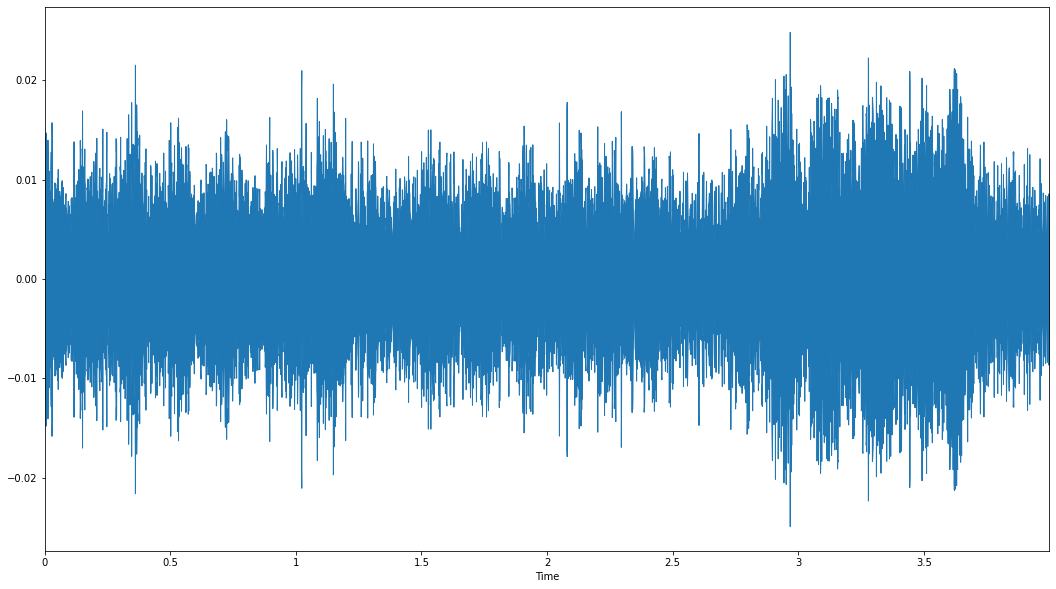

In [131]:
# testing on new data 
filename = r"sample_audio/car_horn.wav"

# pass into librosa loading func
audio, sample_rate = librosa.load(filename, res_type='kaiser_fast') 

# Display Audio
plt.figure(figsize = (18,10))
librosa.display.waveplot(audio, sr = sample_rate)

# pass the audio data into Mfcc Function
mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)

mfccs_scaled_features=mfccs_scaled_features.reshape(1,-1)
print(mfccs_scaled_features)
print(mfccs_scaled_features.shape)

#prediction by DL Model
predicted_label = model.predict_classes(mfccs_scaled_features)
print(predicted_label)

#Printing class name
prediction_class = le.inverse_transform(predicted_label) 
print(prediction_class)

#Play Audio
(ipd.Audio(filename))

[[-106.64777      66.193344    -98.82177       8.654201    -19.321476
     6.403942    -18.889496      9.300698    -17.015398      7.340294
   -28.11161      -0.8700929   -15.694381      2.939238    -13.08879
    14.451415     -7.053008     13.286624     -6.864392      0.4100476
     3.8890994     4.768824     -4.3205595     3.857243     -9.099906
     4.9313917    -5.068691      6.3904643    -2.2792573     4.382885
    -0.73587364    2.9884539    -1.3444165     3.4235551    -2.818768
    -0.20676781   -2.0131347    -0.29044873    4.6918716    -0.51214576]]
(1, 40)
[4]
['drilling']


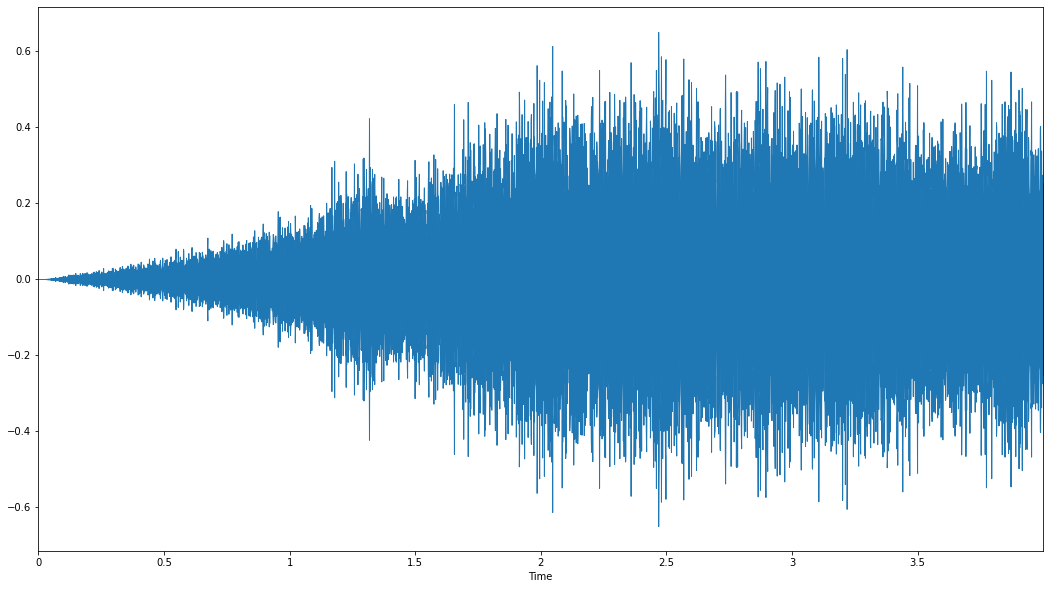

In [132]:
# testing on new data 
filename = r"sample_audio/drilling.wav"

# pass into librosa loading func
audio, sample_rate = librosa.load(filename, res_type='kaiser_fast') 

# Display Audio
plt.figure(figsize = (18,10))
librosa.display.waveplot(audio, sr = sample_rate)

# pass the audio data into Mfcc Function
mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)

mfccs_scaled_features=mfccs_scaled_features.reshape(1,-1)
print(mfccs_scaled_features)
print(mfccs_scaled_features.shape)

#prediction by DL Model
predicted_label = model.predict_classes(mfccs_scaled_features)
print(predicted_label)

#Printing class name
prediction_class = le.inverse_transform(predicted_label) 
print(prediction_class)

#Play Audio
(ipd.Audio(filename))

[[-1.6201204e+02  8.6961006e+01 -1.7699532e+01  3.7743305e+01
  -2.6981344e+01  2.2603523e+01 -1.2762634e+01  1.9585178e+01
  -7.3795695e+00  1.0230817e+01 -1.2329507e+01  1.4141023e+01
  -1.0291466e+01  1.4851977e+01 -3.5956721e+00  7.9914298e+00
  -9.9443750e+00  2.9861157e+00 -1.0833521e+01  6.8507228e+00
   3.2930115e-01  3.5014648e+00  6.8857580e-01  1.8191669e+00
  -3.0795743e+00  4.4436402e+00 -4.7444901e+00  2.6481719e+00
  -6.0189214e+00  8.3692226e+00 -4.1092944e+00  1.3303447e+00
  -4.7978373e+00  8.8858739e-02 -4.3167686e+00  6.0157995e+00
  -4.2702107e+00  1.3360858e+00 -5.0219164e+00  6.2901598e-01]]
(1, 40)
[7]
['jackhammer']


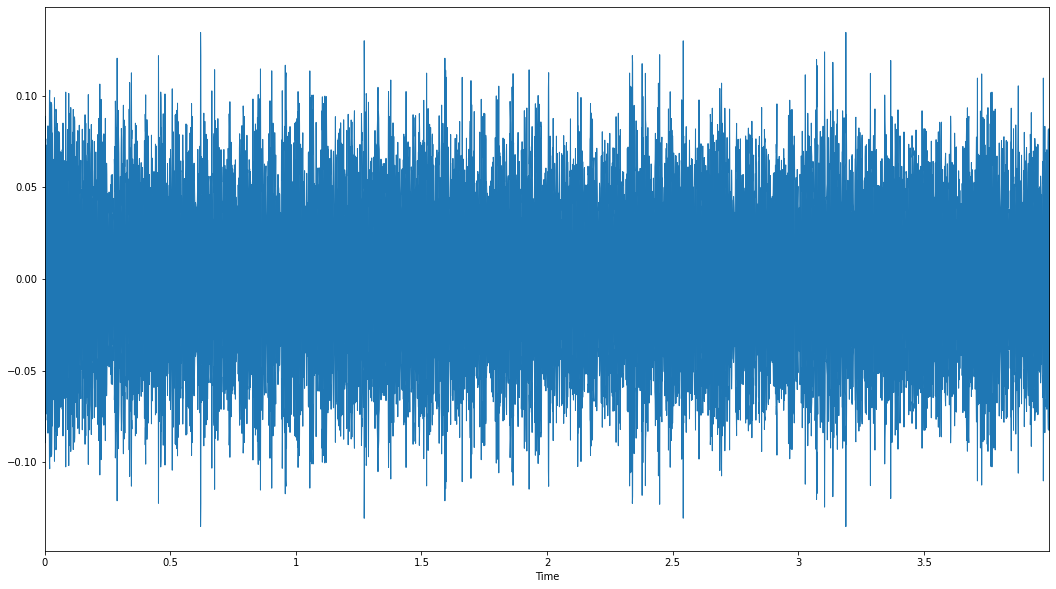

In [141]:
# testing on new data 
filename = r"sample_audio/jackhammer.wav"

# pass into librosa loading func
audio, sample_rate = librosa.load(filename, res_type='kaiser_fast') 

# Display Audio
plt.figure(figsize = (18,10))
librosa.display.waveplot(audio, sr = sample_rate)

# pass the audio data into Mfcc Function
mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)

mfccs_scaled_features=mfccs_scaled_features.reshape(1,-1)
print(mfccs_scaled_features)
print(mfccs_scaled_features.shape)

#prediction by DL Model
predicted_label = model.predict_classes(mfccs_scaled_features)
print(predicted_label)

#Printing class name
prediction_class = le.inverse_transform(predicted_label) 
print(prediction_class)

#Play Audio
(ipd.Audio(filename))

[[-158.41556     114.97013     -23.793324     22.28602      -2.9166045
    28.796835      0.24752492   38.413383      5.1976414    15.559683
    -5.6178913    18.293362      6.9584665    10.371144     -5.7035427
     8.537078      3.753834      3.0672889   -10.288147     10.90595
     9.739539      5.2375703    -6.868305      7.497032      2.4906092
     4.0028977     3.8362947     2.534984      3.9406943     2.0725114
     3.4761233     3.4265018    -2.6410546    -1.7720577     6.9727073
     8.134104      3.7407205     3.696215     -2.0141115     4.5557976 ]]
(1, 40)
[5]
['engine_idling']


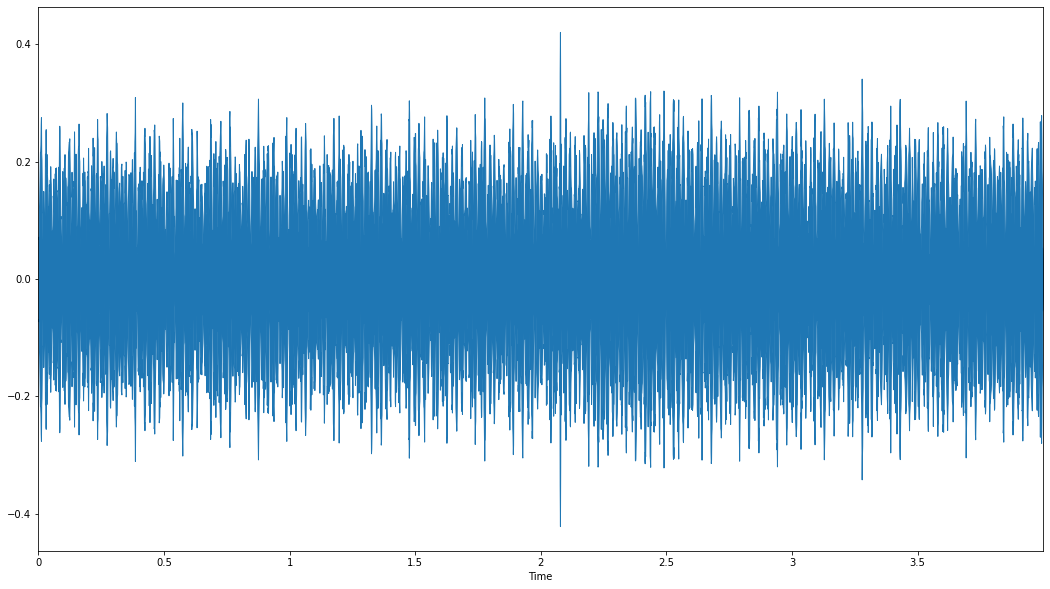

In [135]:
# testing on new data 
filename = r"sample_audio/engine_idiling.wav"

# pass into librosa loading func
audio, sample_rate = librosa.load(filename, res_type='kaiser_fast') 

# Display Audio
plt.figure(figsize = (18,10))
librosa.display.waveplot(audio, sr = sample_rate)

# pass the audio data into Mfcc Function
mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)

mfccs_scaled_features=mfccs_scaled_features.reshape(1,-1)
print(mfccs_scaled_features)
print(mfccs_scaled_features.shape)

#prediction by DL Model
predicted_label = model.predict_classes(mfccs_scaled_features)
print(predicted_label)

#Printing class name
prediction_class = le.inverse_transform(predicted_label) 
print(prediction_class)

#Play Audio
(ipd.Audio(filename))

[[-268.6005      -19.403725    -76.374146      0.83406645  -32.71365
    19.642958    -15.335141     14.387652    -21.860619     27.640366
   -10.126339      5.794981    -22.2527        7.1978827     2.9324489
    21.53895      -7.0290103    10.408652     -1.5954188     7.208435
    -4.4455056     1.5447601    -3.7216232     3.9283955    -2.779119
     8.866242      1.0720572     7.0318046    -0.49507535   -8.240744
   -11.65991       8.578922     13.76181       8.043346     -2.5720787
     6.1029863    -6.1440463    -7.903526     -7.0783315     5.215793  ]]
(1, 40)
[4]
['drilling']


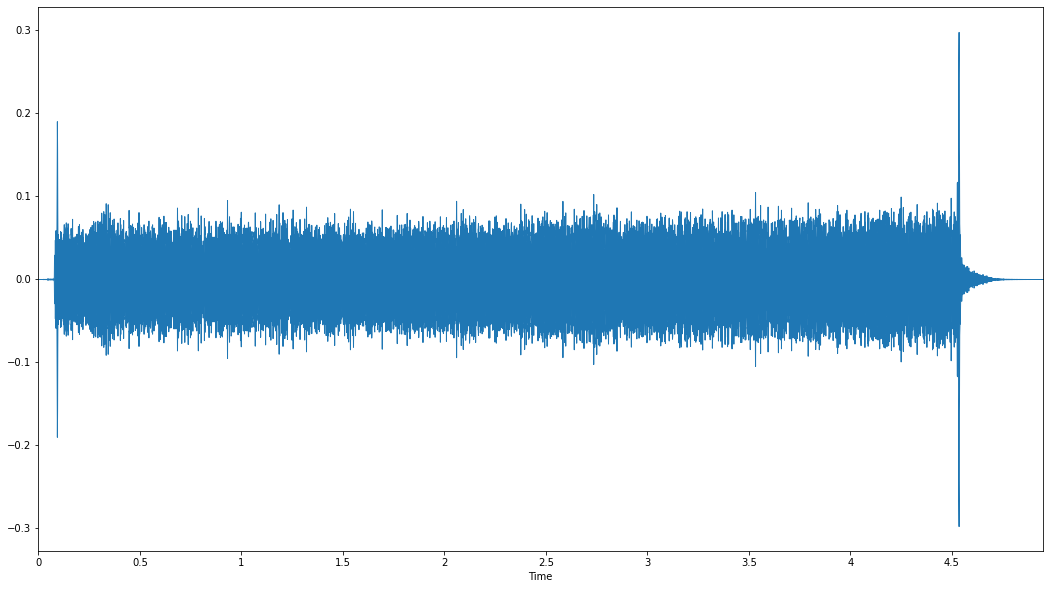

In [142]:
# testing on new data 
filename = r"sample_audio/electric-drill-06.wav"

# pass into librosa loading func
audio, sample_rate = librosa.load(filename, res_type='kaiser_fast') 

# Display Audio
plt.figure(figsize = (18,10))
librosa.display.waveplot(audio, sr = sample_rate)

# pass the audio data into Mfcc Function
mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)

mfccs_scaled_features=mfccs_scaled_features.reshape(1,-1)
print(mfccs_scaled_features)
print(mfccs_scaled_features.shape)

#prediction by DL Model
predicted_label = model.predict_classes(mfccs_scaled_features)
print(predicted_label)

#Printing class name
prediction_class = le.inverse_transform(predicted_label) 
print(prediction_class)

#Play Audio
(ipd.Audio(filename))

- #####################################################################################################################